## QC - Model
<ol>
<li>

In [1]:
import random
import os
import sys
import warnings
import datetime
import time
import pandas as pd

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io

import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

#TensorFlow libraries
#TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, models, losses

from tqdm import tqdm
print(f'TensorFlow Version:',tf.__version__)
print(tf.config.list_physical_devices())

import scipy.signal as sc
from scipy.signal import butter, filtfilt


from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization
from tensorflow_estimator.python.estimator.api._v2 import estimator as estimator
from keras.api._v2 import keras
from keras.api._v2.keras import losses
from keras.api._v2.keras import models
from keras.api._v2.keras import layers
from keras.api._v2.keras import callbacks
from keras.layers import concatenate, Concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, Activation, MaxPooling2D
from keras.models import Model, load_model
from keras.models import Sequential 

import scipy.signal as sc
from scipy.signal import butter, filtfilt


from Functions_File import  Generate_training_set, retreive_gather,FreqLoss,butter_bandpass_filter,butter_bandstop_filter


TensorFlow Version: 2.9.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
## Model Input: 2D Window Sliding Window over training and test gathers
num_test_gather = 5
    ## Define Outer window shape
out_x,out_y  = 64,256
factor_x,factor_y = 4,4
part_x,part_y =2,2
tot_x,tot_y =635,1600
inn_x,inn_y = int(out_x/factor_x),int(out_y/factor_y)
num_windows_x,num_windows_y= int(np.ceil(tot_x/inn_x)), int(np.ceil(tot_y/inn_y))
num_windows =  num_windows_x*num_windows_y 
    ## Filter function
f_low = 20
f_high = 25
dt = 0.004
fs = 1/dt

In [3]:
## Input Test data an Trained Model
path = 'D:/Thesis/Github/Neural Network/Generated Data/' 
in_data = 'Test Data/TE_g25_IRP_Noised'

Test = pd.read_hdf(path+in_data+'_Normalized.h5', start= 0, stop=num_windows*num_test_gather)
Test_F = pd.read_hdf(path+in_data+'_Filtered.h5', start= 0, stop=num_windows*num_test_gather)
Test_N = pd.read_hdf(path+in_data+'_Filtered_Noised.h5', start= 0, stop=num_windows*num_test_gather)
Test_fac = pd.read_hdf(path+in_data+'_Factors.h5',start= 0, stop=num_windows*num_test_gather)

Test = Test.values.reshape((num_windows*num_test_gather,out_x,out_y,1))
Test_F= Test_F.values.reshape((num_windows*num_test_gather,out_x,out_y,1))
Test_N= Test_N.values.reshape((num_windows*num_test_gather,out_x,out_y,1))
normfac = Test_fac['normfac'].values



In [4]:
# Imput Trained Model
path_model= 'D:/Thesis/Github/Neural Network/Trained Models/' 
in_model = 'LE_progress_50'
input_model = in_model + '_model.h5'
input_checkpoint = in_model + '_checkpoint.h5'
input_checkpoint_pkl = in_model + '_checkpoint.pkl'


loaded_model = tf.keras.models.load_model(path_model+input_model,compile=False)
#loaded_model.compile(loss = FreqLoss, optimizer="adam", metrics=["mean_squared_error"])
#loaded_model = load_model('C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Neural Network/Trained Models/model_tarined_100.h5',compile=False)
preds_test = loaded_model.predict(Test_N, verbose=1)

157/157 [==============================] - 150s 949ms/step


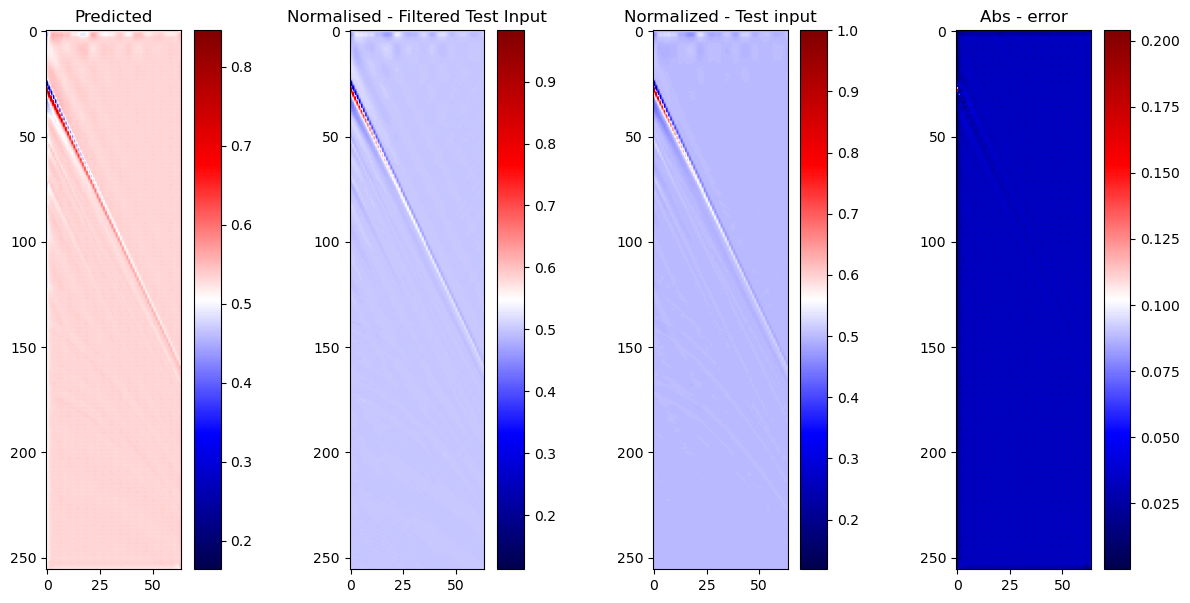

In [5]:
z = 50
a = preds_test[z,:,:].reshape((64,256))
b = Test_N[z,:,:].reshape((64,256))
c = Test[z,:,:].reshape((64,256))
d= np.abs(b-a)

plt.figure(figsize=(15,7))
plt.subplot(141)
plt.imshow(a.T,cmap='seismic')
plt.title('Predicted')
plt.colorbar()
plt.subplot(142)
plt.imshow(b.T,cmap='seismic')
plt.colorbar()
plt.title('Normalised - Filtered Test Input')
plt.subplot(143)
plt.imshow(c.T,cmap='seismic')
plt.title('Normalized - Test input')
plt.colorbar()
plt.subplot(144)
plt.imshow(d.T,cmap='seismic')
plt.title('Abs - error')
plt.colorbar()

In [6]:
Original = retreive_gather(Test,normfac,factor_x,factor_y,tot_x,tot_y,inn_x,inn_y,part_x,part_y)
Original_noise = retreive_gather(Test_N,normfac,factor_x,factor_y,tot_x,tot_y,inn_x,inn_y,part_x,part_y)
Original_filtered = retreive_gather(Test_F,normfac,factor_x,factor_y,tot_x,tot_y,inn_x,inn_y,part_x,part_y)
Predicted = retreive_gather(preds_test,normfac,factor_x,factor_y,tot_x,tot_y,inn_x,inn_y,part_x,part_y)   


The MAE of the input data was: 276.7148083170215
The Max Abs Error of the input data was:11894.3359375


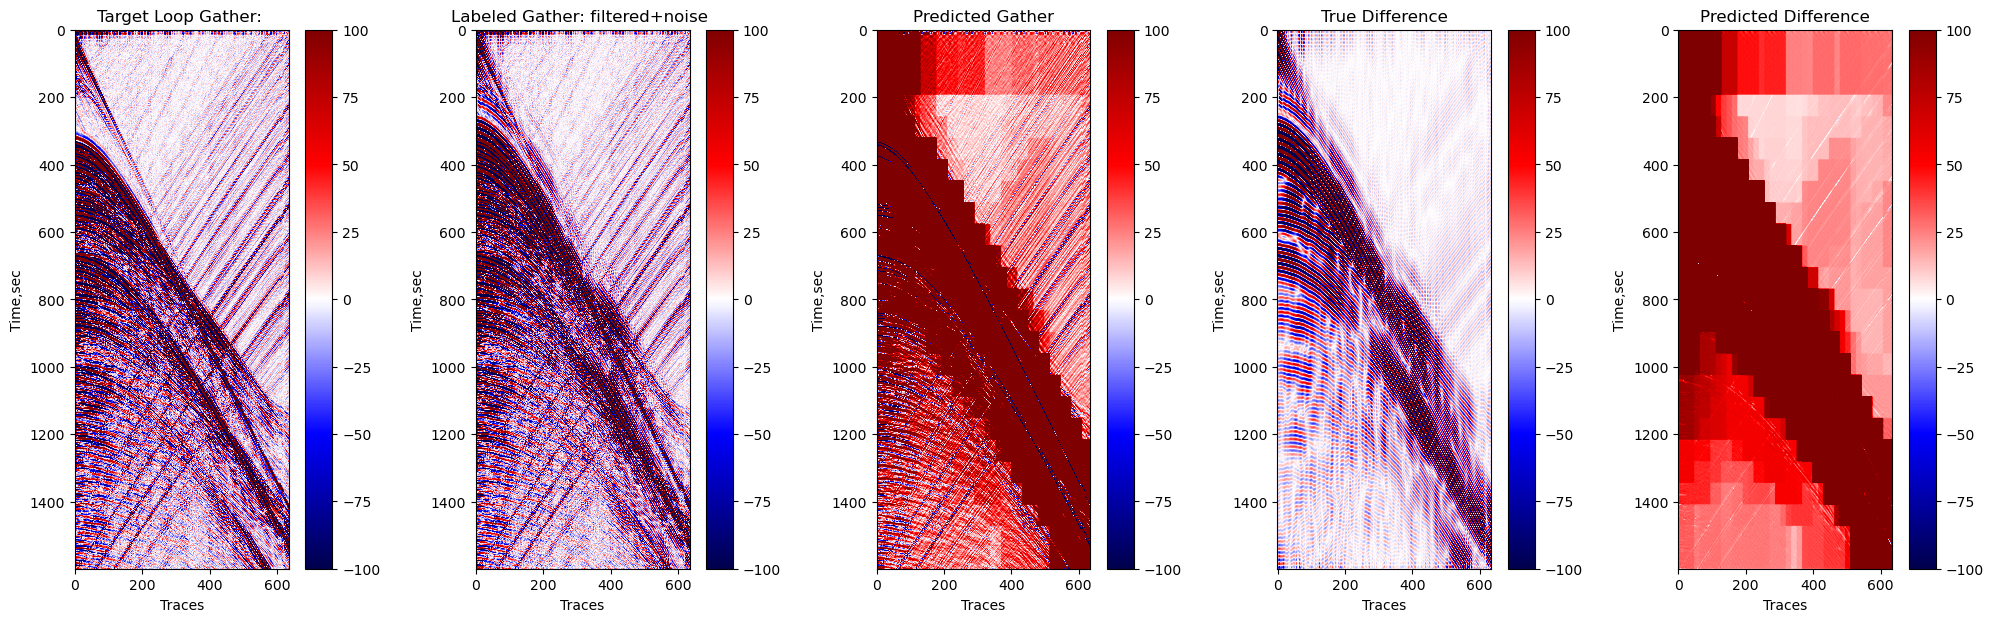

In [7]:
plt.figure(figsize=(25,7))

plt.subplot(151)
plt.imshow(Original.T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Target Loop Gather: ')
plt.colorbar()
plt.subplot(152)
plt.imshow((Original_noise).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Labeled Gather: filtered+noise ')
plt.colorbar()
plt.subplot(153)
plt.imshow((Predicted).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Gather')
plt.colorbar()
plt.subplot(154)
plt.imshow((Original - Original_noise).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('True Difference')
plt.colorbar()
plt.subplot(155)
plt.imshow((Predicted - Original_noise).T, cmap='seismic',vmax=100,vmin=-100)
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Difference')
plt.colorbar()



print('The MAE of the input data was: ' + str(np.abs(np.mean(Original-Predicted))))
print('The Max Abs Error of the input data was:' + str((np.max(Original))-np.max(Predicted)))

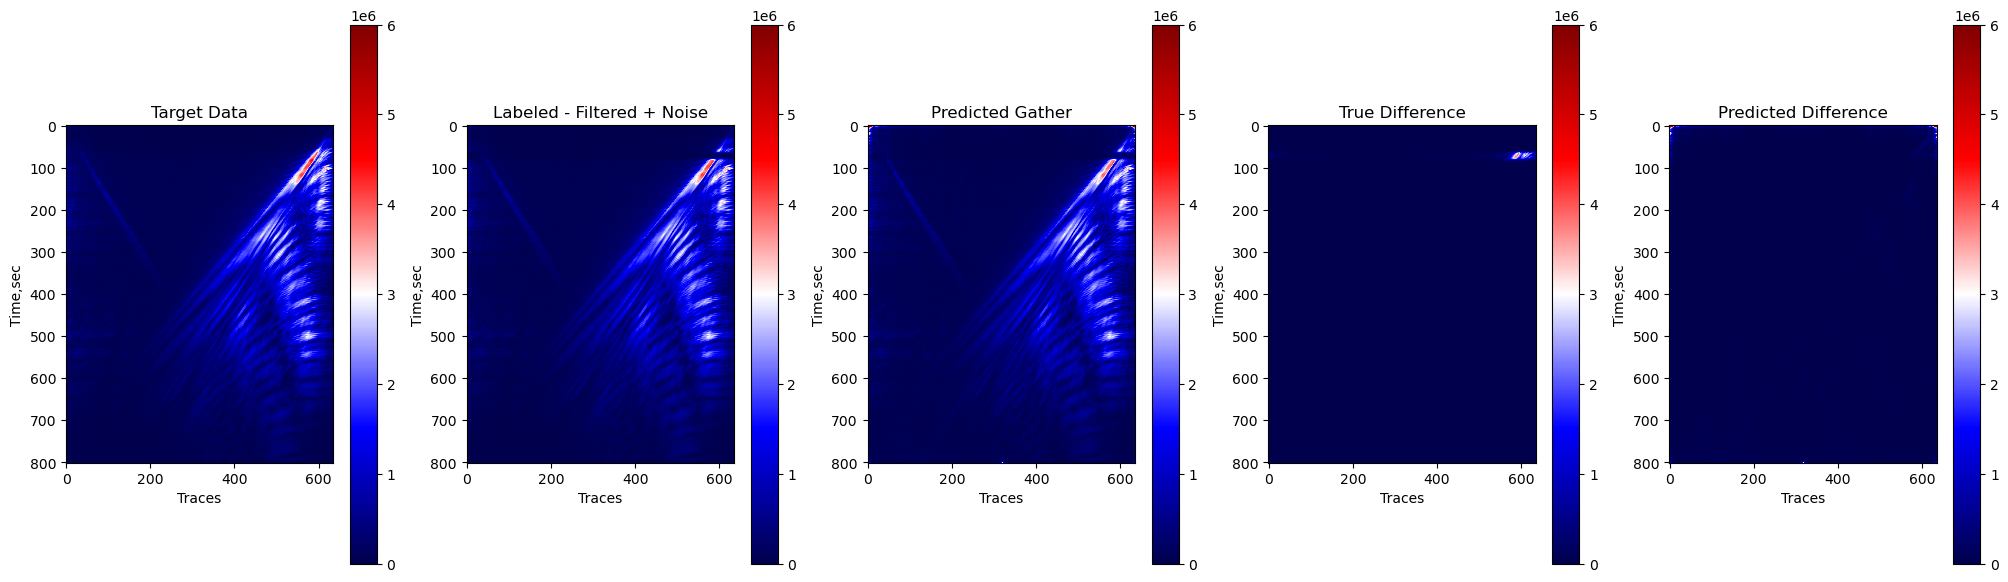

In [8]:
Original_rfft = np.abs(np.fft.rfft2(Original))
filtered_rfft = np.abs(np.fft.rfft2(Original_filtered))
noised_rfft = np.abs(np.fft.rfft2(Original_noise))
Predicted = butter_bandstop_filter(Predicted,1,5,250)
Predicted_rfft = np.abs(np.fft.rfft2(Predicted))


plt.figure(figsize=(25,7))
plt.title(in_model)
plt.subplot(151)
plt.imshow(Original_rfft.T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Target Data')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(152)
plt.imshow((noised_rfft).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Labeled - Filtered + Noise')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(153)
plt.imshow((Predicted_rfft).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Gather')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(154)
plt.imshow((Original_rfft - noised_rfft).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('True Difference')
plt.colorbar()
plt.clim(0,6e6)
plt.subplot(155)
plt.imshow((Predicted_rfft -noised_rfft).T, cmap='seismic')
plt.xlabel('Traces')
plt.ylabel('Time,sec')
plt.title('Predicted Difference')
plt.colorbar()
plt.clim(0,6e6)



(0.0, 400000.0)

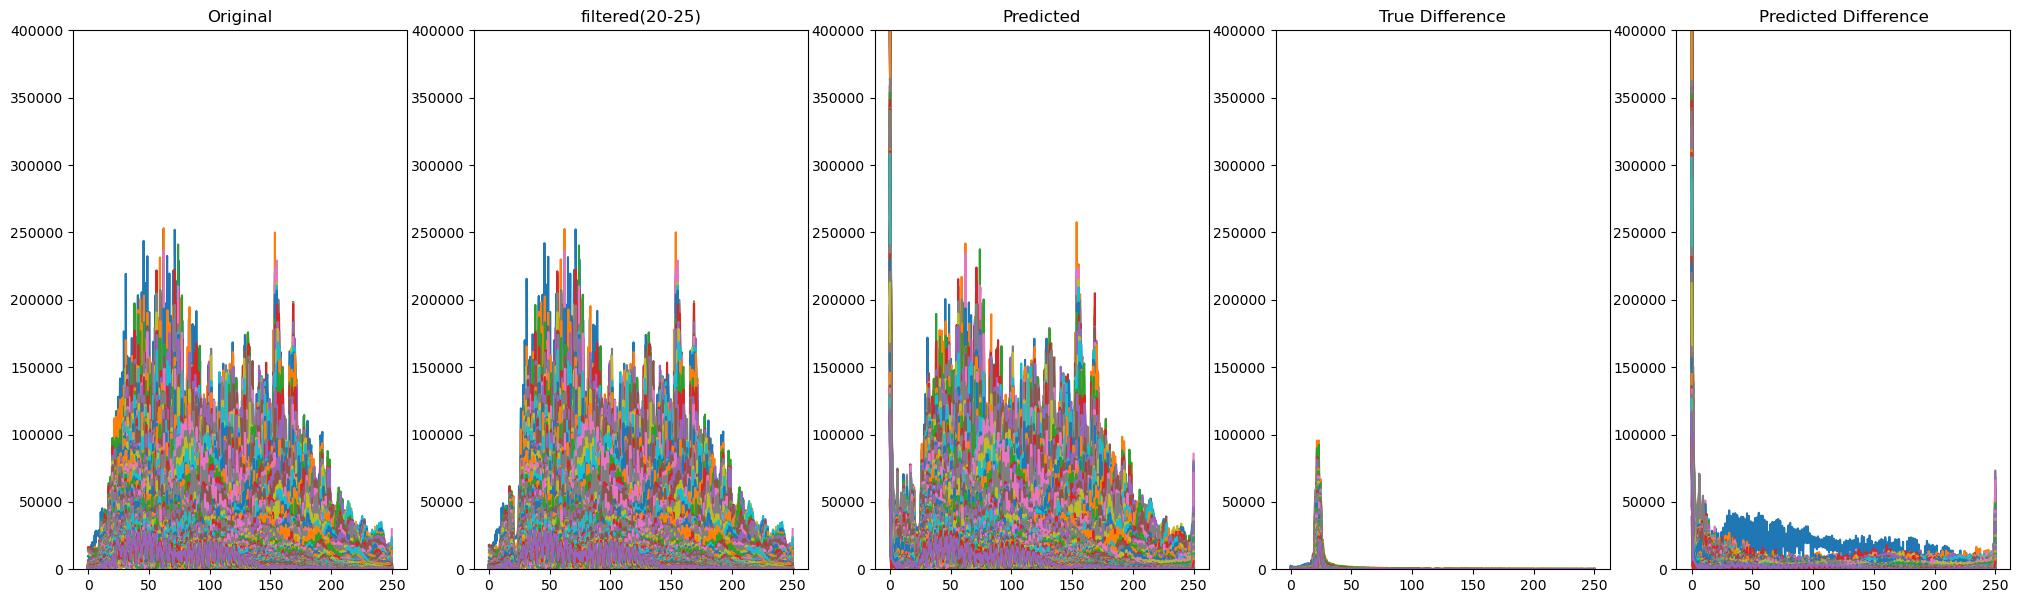

In [9]:
## Plot Db scale
Original_rfft = np.abs(np.fft.rfft(Original))
filtered_rfft = np.abs(np.fft.rfft(Original_filtered))
noise_rfft = np.abs(np.fft.rfft(Original_noise))
Predicted_rfft = np.abs(np.fft.rfft(Predicted))
freq = np.linspace(0,250,801)
plt.figure(figsize=(25,7))
plt.subplot(151)
plt.plot(freq,np.abs(Original_rfft.T))
plt.title('Original')
plt.ylim(0,400000)
plt.subplot(152)
plt.plot(freq,np.abs(noise_rfft.T))
plt.title('filtered(20-25)')
plt.ylim(0,400000)
plt.subplot(153)
plt.plot(freq,np.abs(Predicted_rfft.T))
plt.title('Predicted')
plt.ylim(0,400000)
plt.subplot(154)
plt.plot(freq,np.abs(Original_rfft - noise_rfft).T)
plt.title('True Difference')
plt.ylim(0,400000)
plt.subplot(155)
plt.plot(freq,np.abs(Predicted_rfft - noise_rfft).T)
plt.title('Predicted Difference')
plt.ylim(0,400000)


Text(0.5, 1.0, 'Predicted Difference')

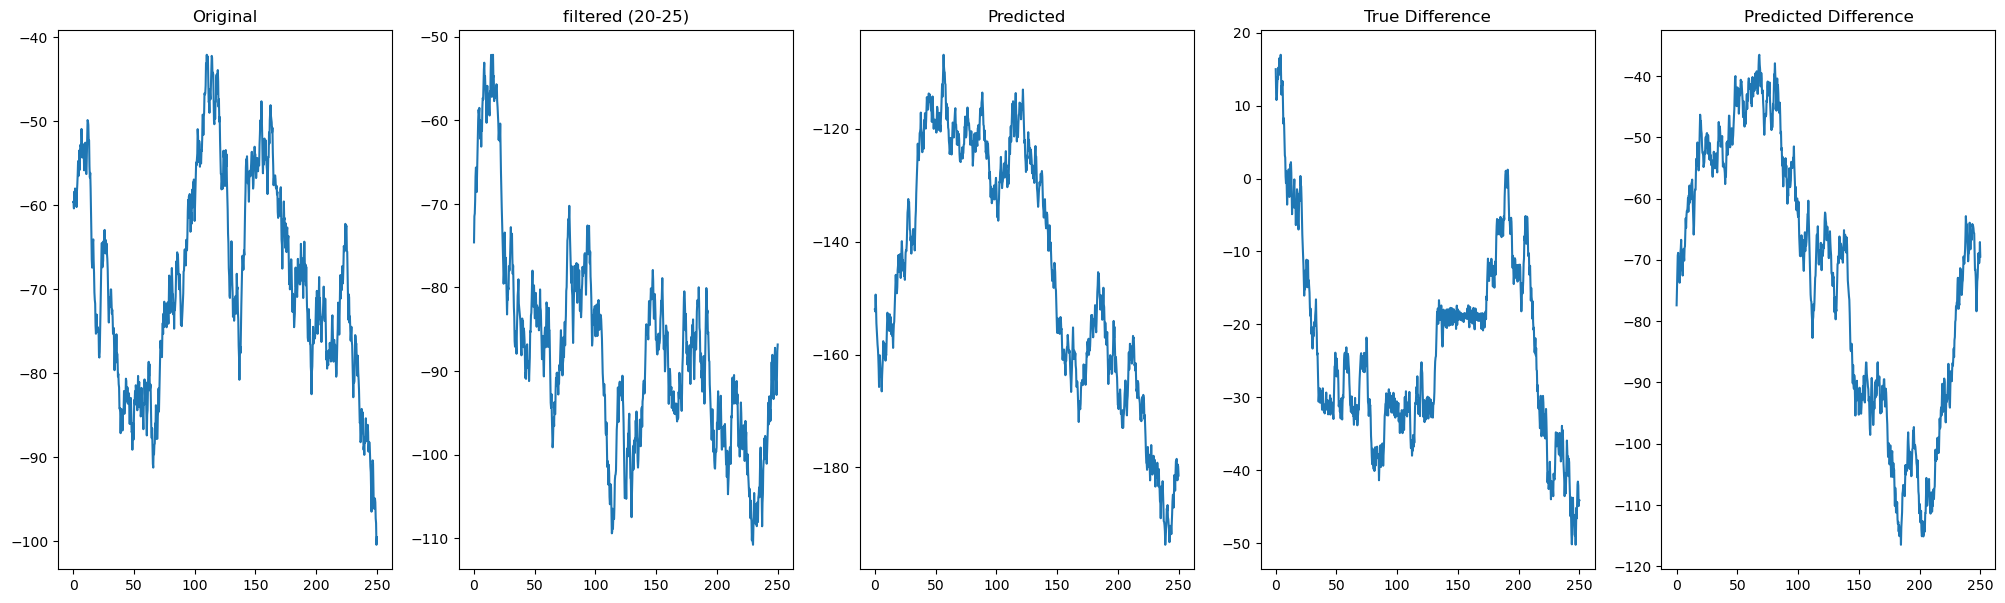

In [10]:
Original_phi= np.degrees(np.angle(np.fft.rfft2(Original)))
filtered_phi =np.degrees(np.angle(np.fft.rfft2(Original_filtered)))
Predicted_phi =np.degrees(np.angle(np.fft.rfft2(Predicted)))

ix =80

freq = np.linspace(0,250,801)
plt.figure(figsize=(25,7))
plt.subplot(151)
plt.plot(freq,(np.unwrap(Original_phi[ix,:])).T)
plt.title('Original')
plt.subplot(152)
plt.plot(freq,(np.unwrap(filtered_phi[ix,:])).T)
plt.title('filtered (20-25)')
plt.subplot(153)
plt.plot(freq,(np.unwrap(Predicted_phi[ix,:])).T)
plt.title('Predicted')
plt.subplot(154)
plt.plot(freq,(np.unwrap(Original_phi[ix,:] - filtered_phi[ix,:])).T)
plt.title('True Difference')
plt.subplot(155)
plt.plot(freq,(np.unwrap(Predicted_phi[ix,:] - filtered_phi[ix,:])).T)
plt.title('Predicted Difference')


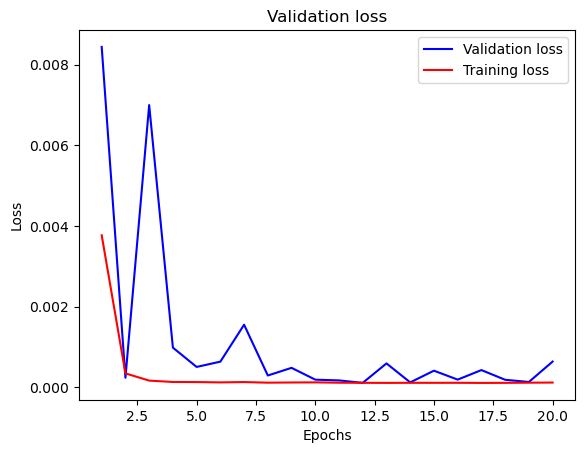

In [11]:
import pickle

input_checkpoint_pkl = in_model + '_checkpoint.pkl'
with open(path_model+ input_checkpoint_pkl, 'rb') as file:
    history = pickle.load(file)

# Restore the mean squared values, loss, and val_loss for each epoch
mse = history['mean_squared_error']
loss = history['loss']
val_loss = history['val_loss']

# Plot the validation error
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()